In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]


train_path = '/content/drive/MyDrive/dataset-xgboost/training'
valid_path = '/content/drive/MyDrive/dataset-xgboost/validation'

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
folders = glob('/content/drive/MyDrive/dataset-xgboost/training/*')


In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset-xgboost/training',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset-xgboost/validation',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)


Found 1263 images belonging to 3 classes.
Found 464 images belonging to 3 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set), #10
  validation_steps=len(test_set) #2
)

Epoch 1/100
79/79 [==============================] - 1176s 14s/step - loss: 0.6690 - accuracy: 0.7237 - val_loss: 0.1910 - val_accuracy: 0.9289
Epoch 2/100
79/79 [==============================] - 24s 305ms/step - loss: 0.2927 - accuracy: 0.8822 - val_loss: 0.1344 - val_accuracy: 0.9440
Epoch 3/100
79/79 [==============================] - 24s 307ms/step - loss: 0.3272 - accuracy: 0.8942 - val_loss: 0.0632 - val_accuracy: 0.9849
Epoch 4/100
79/79 [==============================] - 25s 310ms/step - loss: 0.2087 - accuracy: 0.9220 - val_loss: 0.1531 - val_accuracy: 0.9440
Epoch 5/100
79/79 [==============================] - 25s 312ms/step - loss: 0.1515 - accuracy: 0.9485 - val_loss: 0.0692 - val_accuracy: 0.9763
Epoch 6/100
79/79 [==============================] - 25s 311ms/step - loss: 0.1668 - accuracy: 0.9398 - val_loss: 0.3767 - val_accuracy: 0.8793
Epoch 7/100
79/79 [==============================] - 25s 312ms/step - loss: 0.1544 - accuracy: 0.9394 - val_loss: 0.4209 - val_accuracy:

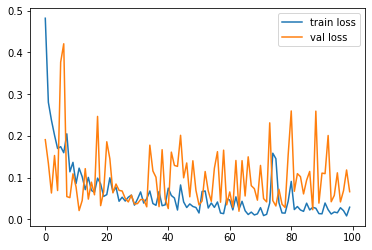

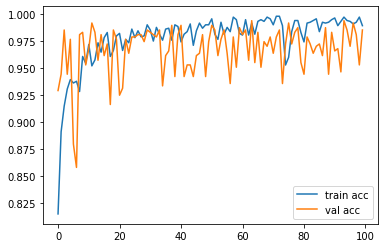

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_set, 464 // 16+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['covid', 'normal', 'pneumonia']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[138   2   0]
 [  0 156   0]
 [  0   5 163]]
Classification Report
              precision    recall  f1-score   support

       covid       1.00      0.99      0.99       140
      normal       0.96      1.00      0.98       156
   pneumonia       1.00      0.97      0.98       168

    accuracy                           0.98       464
   macro avg       0.99      0.99      0.99       464
weighted avg       0.99      0.98      0.98       464

